In [1]:
import rasterio as rio
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error
import seaborn as sns
from functools import reduce
from collections import defaultdict
from skimage.metrics import structural_similarity as ssim
#from pytorch_msssim import ssim
from skimage.metrics import mean_squared_error
import numpy as np
from s2cloudless import S2PixelCloudDetector

C:\Users\oriol.alas\VENVS\mlvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def scaled(x):
    min_val, max_val = np.percentile(x, (2, 98))

    # Scale the pixel values to the range of 0-255
    return np.interp(x, (min_val, max_val), (0.1, 255)).astype(np.uint8)

def sigmoid(x):
    return 255 / (1 + np.exp(-2 * (scaled(x) / 255 - 0.5)))

def get_detect_cloud_bands(img):
    bands = [sigmoid(img.read(b)) for b in img.indexes]
    bands = np.stack(bands)
    return bands.transpose(1,2,0).astype(np.uint8)

def get_tci(img):
    r = scaled(img.read(4))
    g = scaled(img.read(3))
    b = scaled(img.read(2))
    rgb = np.stack([r, g, b])
    rgb = (rgb.transpose(1, 2, 0)).astype(np.uint8)
    return rgb

def to_tci(img):
    return img[:, :, [3,2,1]]

def flatten(xs):
    return reduce(lambda x, y: list(x) + list(y), xs)

In [118]:
def calculate_psnr(im1, im2):
    mse = np.mean((im1 - im2) ** 2)
    psnr = 10 * np.log10(255 ** 2 / np.sqrt(mse))
    return psnr.item()

def get_sam(y_true, y_pred):
    """Computes the SAM array."""
    num = (y_true * y_pred).sum()
    den = np.sqrt(np.abs((y_true * y_true).sum())) * np.sqrt(np.abs((y_pred * y_pred).sum()))
    res = (num / den)
    if res > 1:
        res = 1 - (res - int(res))
    return np.arccos(res)
    mat = np.multi(y_true, y_predict)
    mat = tf.reduce_sum(mat, 1)
    mat = mat / K.sqrt(tf.reduce_sum(tf.multiply(y_true, y_true), 1))
    mat = mat / K.sqrt(tf.reduce_sum(tf.multiply(y_predict, y_predict), 1))
    mat = tf.acos(K.clip(mat, -1, 1))

    return tf.reduce_mean(mat)

def get_carl(cloudy_, cloudless_, generated, mask_, w=1):
    clear = np.mean((np.ones_like(cloudy_) - mask_ / 255) * np.abs(cloudy_ - generated))
    cloudy = np.mean(mask_ * np.abs(cloudless_ - generated))
    total = w * np.mean(np.abs(cloudless_ - generated))
    return clear + cloudy + total



In [4]:
img = r"imgs\cr\ok\ROIs2017_winter_s2_102_p926.tif"
img_cloudy = r"imgs\cr\ok\ROIs2017_winter_s2_cloudy_102_p926.tif"
img = rio.open(img)
img_cloudy = rio.open(img_cloudy)

cloud_detector = S2PixelCloudDetector(threshold=0.7, average_over=4, dilation_size=2, all_bands=True)


def get_detect_cloud_bands(img):
    bands = [img.read(b) / 10000 for b in img.indexes]
    bands = np.stack(bands)
    return bands.transpose(1,2,0)

cloudy_bands = get_detect_cloud_bands(img_cloudy)
cloudy_mask = cloud_detector.get_cloud_masks(cloudy_bands[np.newaxis, ...])

In [5]:
img = get_tci(img).astype(int)
img_cloudy = get_tci(img_cloudy).astype(int)

In [6]:
np.array([3,4])[np.newaxis, np.newaxis]

array([[[3, 4]]])

In [10]:
img.shape

(256, 256, 3)

In [16]:
import torch

def get_ssim(img1, img2):
    return ssim(img1, img2)
    img1 = img1[np.newaxis, np.newaxis]
    img2 = img2[np.newaxis, np.newaxis]
    return ssim(img1, img2)

get_sam(img[:, :, 0], img[:, :, 0]), get_carl(img_cloudy[:, :, 0], img[:, :, 0], img[:,:,0], cloudy_mask), get_ssim(img_cloudy[:, :, 0], img[:, :, 0])


C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_26412\2035812807.py:4: UserWarning: Setting data_range based on im1.dtype. data_range = 4294967295. Please specify data_range explicitly to avoid mistakes.
  return ssim(img1, img2)


(0.0, 72.0488904167624, 0.9999999999963989)

C:\Users\oriol.alas\AppData\Local\Temp\ipykernel_26412\843908634.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  psnr = 10 * np.log10(255 ** 2 / np.sqrt(mse))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


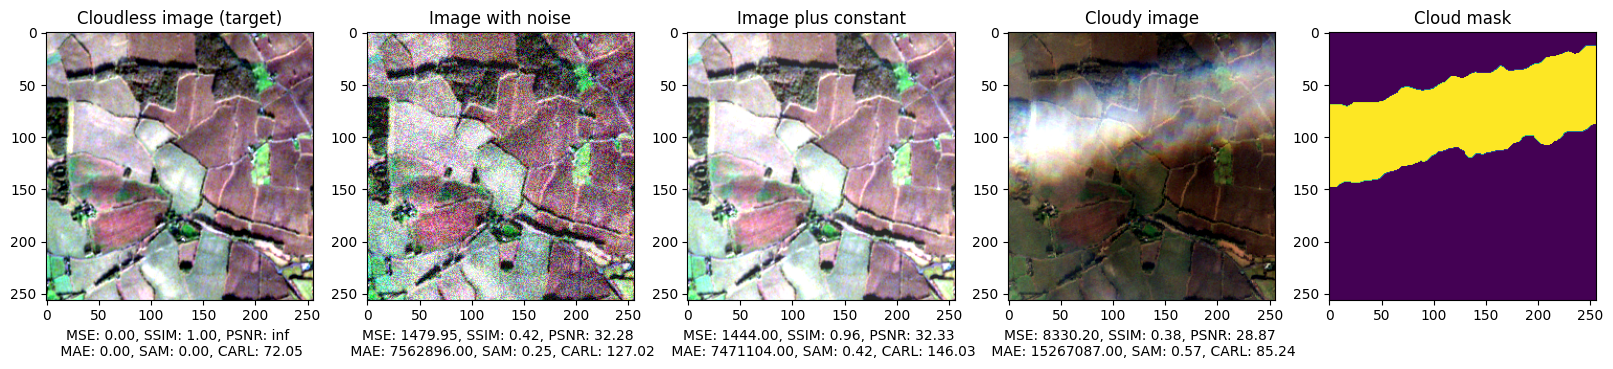

In [129]:
noise = np.ones_like(img) * 0.15 * (img.max() - img.min())
rng = np.random.default_rng()
noise[rng.random(size=noise.shape) > 0.5] *= -1
img_noise = (img + noise).astype(int)
img_const = img + abs(noise).astype(int)

fig, (ax, noisax, plusax, cloudy_ax, mask_ax) = plt.subplots(1, 5, figsize=(20, 4))

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img[:, :, 0], img[:, :, 0], data_range=255)
psnr_ = calculate_psnr(img[:, :, 0], img[:, :, 0])
mae = np.sum(np.absolute((img.astype("float") - img.astype("float"))))
sam = get_sam(img[:, :, 0], img[:, :, 0])
carl = get_carl(img_cloudy[:, :, 0], img[:, :, 0], img[:,:,0], cloudy_mask)


ax.imshow(img, vmin=0, vmax=255)
ax.set_title("Cloudless image (target)")
ax.set_xlabel(f"MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}, PSNR: {psnr_:.2f} \n MAE: {mae:.2f}, SAM: {sam:.2f}, CARL: {carl:.2f}")

mse_none = mean_squared_error(img, img_noise) 
ssim_none = ssim(img[:, :, 0], img_noise[:, :, 0], data_range=255)
psnr_ = calculate_psnr(img[:, :, 0], img_noise[:, :, 0])
mae = np.sum(np.absolute((img.astype("float") - img_noise.astype("float"))))
sam = get_sam(img[:, :, 0], img_noise[:, :, 0])
carl = get_carl(img_cloudy[:, :, 0], img[:, :, 0], img_noise[:,:,0], cloudy_mask)

noisax.imshow(img_noise, vmin=0, vmax=255)
noisax.set_title("Image with noise")
noisax.set_xlabel(f"MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}, PSNR: {psnr_:.2f} \n MAE: {mae:.2f}, SAM: {sam:.2f}, CARL: {carl:.2f}")

mse_none = mean_squared_error(img, img_const) 
ssim_none = ssim(img[:, :, 0], img_const[:, :, 0], data_range=255)
psnr_ = calculate_psnr(img[:, :, 0], img_const[:, :, 0])
mae = np.sum(np.absolute((img.astype("float") - img_const.astype("float"))))
sam = get_sam(img[:, :, 0], img_const[:, :, 0])
carl = get_carl(img_cloudy[:, :, 0], img[:, :, 0], img_const[:,:,0], cloudy_mask)

plusax.imshow(img_const, vmin=0, vmax=255)
plusax.set_title("Image plus constant")
plusax.set_xlabel(f"MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}, PSNR: {psnr_:.2f} \n MAE: {mae:.2f}, SAM: {sam:.2f}, CARL: {carl:.2f}")

mse_none = mean_squared_error(img, img_cloudy) 
ssim_none = ssim(img[:, :, 0], img_cloudy[:, :, 0], data_range=255)
psnr_ = calculate_psnr(img[:, :, 0], img_cloudy[:, :, 0])
mae = np.sum(np.absolute((img.astype("float") - img_cloudy.astype("float"))))
sam = get_sam(img[:, :, 0], img_cloudy[:, :, 0])
carl = get_carl(img_cloudy[:, :, 0], img[:, :, 0], img_cloudy[:,:,0], cloudy_mask)

cloudy_ax.imshow(img_cloudy, vmin=0, vmax=255)
cloudy_ax.set_title("Cloudy image")
cloudy_ax.set_xlabel(f"MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}, PSNR: {psnr_:.2f} \n MAE: {mae:.2f}, SAM: {sam:.2f}, CARL: {carl:.2f}")

mask_ax.imshow(cloudy_mask[0])
mask_ax.set_title("Cloud mask")

fig.savefig(r"C:\Users\oriol.alas\PROJECTS\LACLASSE\docs\imgs\models\metrics\approach.png")

In [159]:
ssim(img.transpose(2, 0,1), img_cloudy.transpose(2,0,1), multichannel=True, data_range=255, channel_axis=0)
ssim(img.transpose(2, 0,1) / 255, img_cloudy.transpose(2,0,1) / 255, multichannel=True, data_range=255, channel_axis=0)

0.9831607841029427

ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

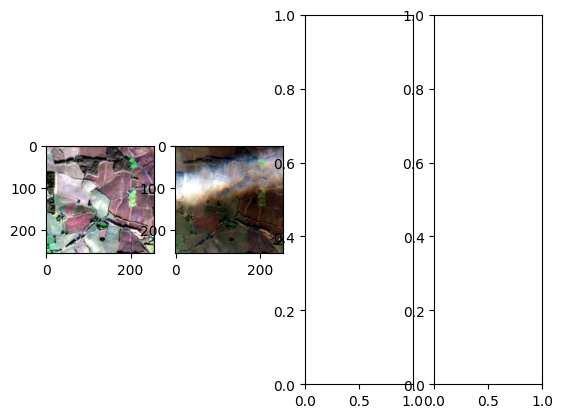

In [137]:
fig, axs = plt.subplots(1, 4)
axs[0].imshow(img, vmin=0, vmax=255)
axs[1].imshow(img_cloudy, vmin=0, vmax=255)
ssim(img.transpose(1,2,0), img_cloudy.transpose(1,2,0), data_range=255, multichannel=True), ssim(img[:,:, 0] / 255 * 0.1, img_cloudy[:,:,0] / 255 * 0.1, data_range=0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(0.12810758077134296, 0.5603346008576654, -19.259820552679102)

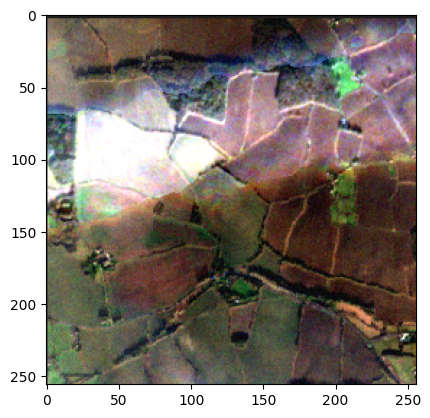

In [116]:
def process(img_cloudy, img, cloudy_mask):
    res = img_cloudy.copy()
    res = res + 10
    noisax.imshow(img_noise, vmin=0, vmax=255)
    for c in range(3):
        res[:,:, c] = (img[:, :, c] - 40 + res[:, :, c] * 0.4) * (cloudy_mask[0] * 0.8) + (1.2 - cloudy_mask[0]) * res[:, :, c]
        
    noise = np.ones_like(res) * 0.02 * (res.max() - res.min())
    rng = np.random.default_rng()
    noise[rng.random(size=noise.shape) > 0.5] *= -1
    res = (res + noise).astype(int)
    res[0:3, :, :] = 30
    res[:, 0:1, :] = 30
    return res.astype(int)
res = process(img_cloudy, img, cloudy_mask)
plt.imshow(res.astype(int), vmin=0, vmax=255)
ssim_none = ssim(img[:, :, 0], res[:, :, 0], data_range=255)
mse_none = mean_squared_error(img, img_cloudy) / 255 / 255
psnr_ = calculate_psnr(img[:, :, 0], img_cloudy[:, :, 0])
mae = np.sum(np.absolute((img.astype("float") - img_cloudy.astype("float"))))
sam = get_sam(img[:, :, 0], img_cloudy[:, :, 0])
carl = get_carl(img_cloudy[:, :, 0], img[:, :, 0], img_cloudy[:,:,0], cloudy_mask)
mse_none, ssim_none, psnr_